In [445]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import numpy as np

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Approximate distribution from histogram and KDE

In [446]:
class histogram_rv(object):
    def __init__(self, samples, n_bins=20):
        self.samples = samples
        self.n_bins = n_bins
        
        self.hist, self.bins = np.histogram(samples, bins=n_bins, density=True)       
        self.hist = np.hstack(([0.], self.hist, [0.]))
        
        self.dx = self.bins[1] - self.bins[0]
        s = 0.5 * (self.bins.max() - self.bins.min()) / (n_bins - 1) 
        self.bins = np.hstack(([-np.inf], self.bins, [np.inf]))
        self.bins[1] -= s
        self.bins[-2] += 1
        
    def pdf(self, x):
        return self.hist[np.searchsorted(self.bins, x) - 1]
    
    def cdf(self, x):
        return np.cumsum(self.hist)[np.searchsorted(self.bins, x) - 1] * self.dx

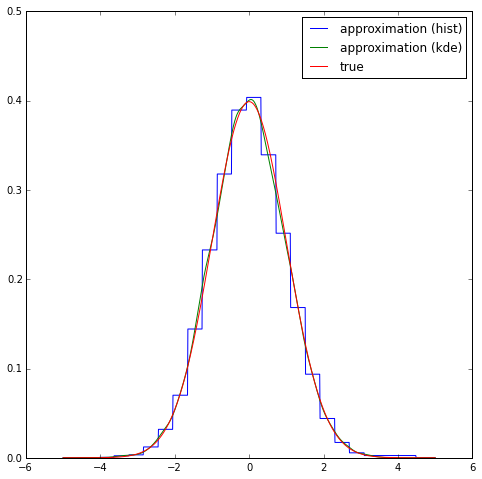

In [447]:
from scipy.stats import norm
from scipy.stats import gaussian_kde

d = np.random.normal(size=10000)
histogram = histogram_rv(d)
kde = gaussian_kde(d)

x = np.linspace(-5, 5, num=1000)

plt.plot(x, histogram.pdf(x), "b", label="approximation (hist)")
plt.plot(x, kde.pdf(x), "g", label="approximation (kde)")
plt.plot(x, norm.pdf(x), "r", label="true")
plt.ylim(0.0, 0.5)
plt.legend(loc="best")
plt.show()

# Approximate likelihood ratios

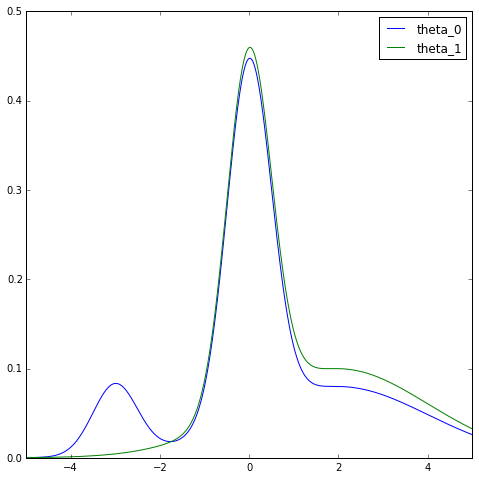

In [448]:
def generate(n_samples, components, weights):
    _, c = np.where(np.random.multinomial(1, weights, n_samples) == 1)
    samples = []
    
    for i in range(n_samples):
        samples.append(components[c[i]].rvs())
        
    return np.array(samples)

components = [norm(loc=0.0, scale=0.5), norm(loc=2.0, scale=2.0), norm(loc=-3.0, scale=0.5)]
w_0 =        [0.5,                      0.4,                      0.1] 
w_1 =        [0.5,                      0.5,                      0.0] 

w_0 = np.array(w_0)
w_0 /= w_0.sum()
w_1 = np.array(w_1)
w_1 /= w_1.sum()

x = np.linspace(-5, 5, num=1000)
plt.plot(x, sum(c.pdf(x) * w for c, w in zip(components, w_0)), label="theta_0")
plt.plot(x, sum(c.pdf(x) * w for c, w in zip(components, w_1)), label="theta_1")
plt.xlim(-5, 5)
plt.legend()
plt.show()

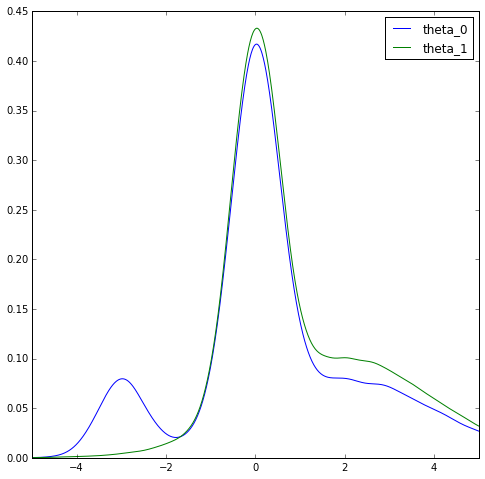

In [449]:
# Dont know any way to compose distributions from base scipy.stats distributions
# So let's use KDE approximates instead

d_0 = generate(100000, components, w_0)
d_1 = generate(100000, components, w_1)

p_theta_0 = gaussian_kde(d_0)
p_theta_1 = gaussian_kde(d_1)

x = np.linspace(-5, 5, num=1000)
plt.plot(x, p_theta_0.pdf(x), label="theta_0")
plt.plot(x, p_theta_1.pdf(x), label="theta_1")
plt.xlim(-5, 5)
plt.legend()
plt.show()

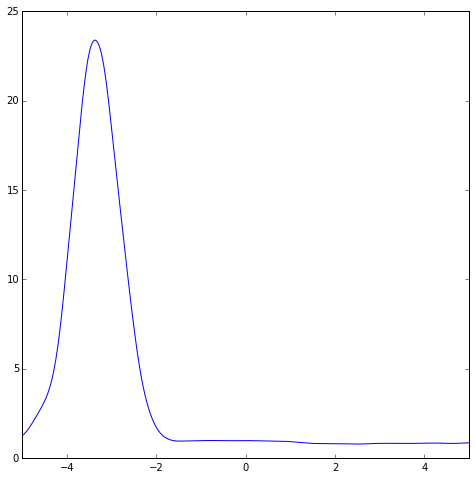

In [452]:
def likelihood_ratio(d, p_theta_0, p_theta_1):
    with np.warnings.catch_warnings():
        np.warnings.simplefilter("ignore")
        r = p_theta_0.pdf(d) / p_theta_1.pdf(d)
    r[np.isnan(r)] = 0
    r[np.isinf(r)] = 0   
    return r

x = np.linspace(-5, 5, num=1000)
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1))
plt.xlim(-5, 5)
plt.show()

In [453]:
# Build a classification task between the two full distributions
n_samples = 100000
d_0 = generate(n_samples // 2, components, w_0)
d_1 = generate(n_samples // 2, components, w_1)
X = np.hstack((d_0, d_1)).reshape(-1, 1)
y = np.ones(n_samples)
y[:n_samples // 2] = 0

# Build a classifier
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV()
clf.fit(X, y)

n_samples = 100000
d_0 = generate(n_samples, components, w_0)
d_1 = generate(n_samples, components, w_1)

p_s_theta_0 = gaussian_kde(clf.decision_function(d_0.reshape(-1, 1)))
p_s_theta_1 = gaussian_kde(clf.decision_function(d_1.reshape(-1, 1)))

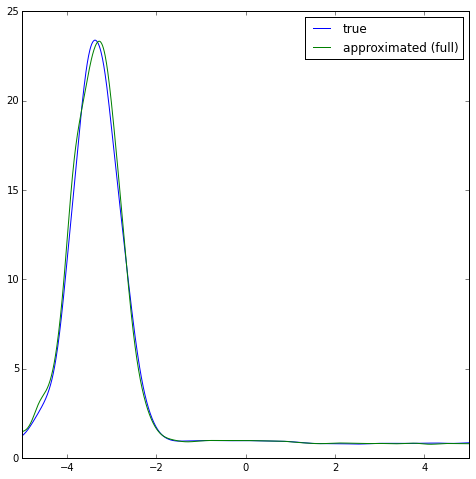

In [457]:
x = np.linspace(-5, 5, num=1000)
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")
plt.plot(x, likelihood_ratio(clf.decision_function(x.reshape(-1, 1)), p_s_theta_0, p_s_theta_1), label="approximated (full)")
plt.xlim(-5, 5)
plt.legend()
plt.show()

In [455]:
def likelihood_ratio_statistic(d, p_theta_0, p_theta_1):
    r = likelihood_ratio(d, p_theta_0, p_theta_1)
    return np.prod(r[r != 0])

print(likelihood_ratio_statistic(d_0[:100], p_theta_0, p_theta_1))
print(likelihood_ratio_statistic(d_1[:100], p_theta_0, p_theta_1))
print(likelihood_ratio_statistic(clf.decision_function(d_0[:100].reshape(-1, 1)), p_s_theta_0, p_s_theta_1))
print(likelihood_ratio_statistic(clf.decision_function(d_1[:100].reshape(-1, 1)), p_s_theta_0, p_s_theta_1))

# Not sure if differences are due to numerical issues, imprecision of the classifiers, or other things
# But at least, orders of magnitude are OK

197413707894.0
0.000248773263967
87359326670.3
0.000317622299995
